<a href="https://colab.research.google.com/github/fjadidi2001/Artificial_Intelligence_Learning/blob/master/classification_using_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Loading and Preparation


x_train shape: (60000, 784)
x_test shape: (10000, 784)


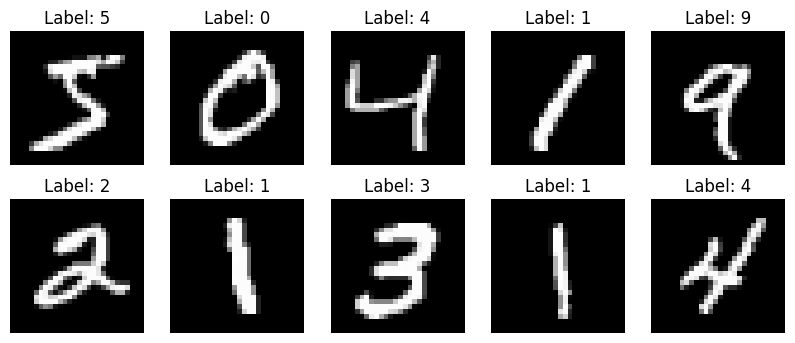

In [23]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the data into vectors in R^784
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# Visualize some sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


# Step 2: Performing SVD


U[0] shape: (5923, 784)
S[0] shape: (784,)
Vt[0] shape: (784, 784)


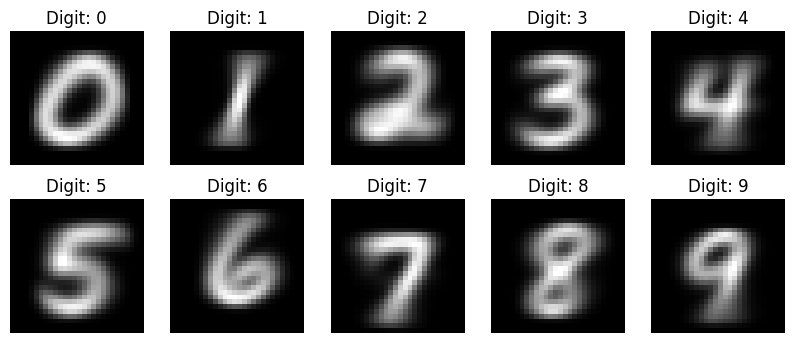

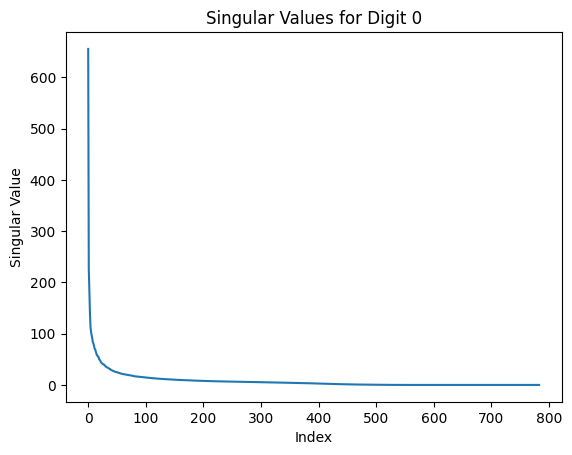

In [24]:
from sklearn.decomposition import TruncatedSVD

# Perform SVD on each digit
U = {}
S = {}
Vt = {}
digits = range(10)

for digit in digits:
    idx = np.where(y_train == digit)[0]
    X_digit = x_train[idx, :]
    svd = TruncatedSVD(n_components=min(X_digit.shape))
    U[digit] = svd.fit_transform(X_digit)
    S[digit] = svd.singular_values_
    Vt[digit] = svd.components_

# Visualize U, S, and Vt matrices for one digit (e.g., digit 0)
digit = 0
print(f"U[{digit}] shape: {U[digit].shape}")
print(f"S[{digit}] shape: {S[digit].shape}")
print(f"Vt[{digit}] shape: {Vt[digit].shape}")

# Display the first singular vector (basis) for each digit
plt.figure(figsize=(10, 4))
for digit in digits:
    plt.subplot(2, 5, digit + 1)
    plt.imshow(Vt[digit][0].reshape(28, 28), cmap='gray')
    plt.title(f"Digit: {digit}")
    plt.axis('off')
plt.show()

# Show singular values for digit 0
plt.figure()
plt.plot(S[0])
plt.title(f"Singular Values for Digit 0")
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.show()


# Step 3: Projection and Classification


In [25]:
# Project test data onto the bases
projections = {}
for digit in digits:
    projections[digit] = np.dot(x_test, Vt[digit].T)

# Classify based on least squares residuals
y_pred_test = np.zeros(x_test.shape[0])
residuals_test = np.zeros((x_test.shape[0], len(digits)))
for i in range(x_test.shape[0]):
    residuals = {}
    for digit in digits:
        reconstruction = np.dot(projections[digit][i], Vt[digit])
        residual = np.linalg.norm(x_test[i] - reconstruction)
        residuals[digit] = residual
        residuals_test[i, digit] = residual
    y_pred_test[i] = min(residuals, key=residuals.get)

# Project train data onto the bases
projections_train = {}
for digit in digits:
    projections_train[digit] = np.dot(x_train, Vt[digit].T)

# Classify based on least squares residuals for train data
y_pred_train = np.zeros(x_train.shape[0])
residuals_train = np.zeros((x_train.shape[0], len(digits)))
for i in range(x_train.shape[0]):
    residuals = {}
    for digit in digits:
        reconstruction = np.dot(projections_train[digit][i], Vt[digit])
        residual = np.linalg.norm(x_train[i] - reconstruction)
        residuals[digit] = residual
        residuals_train[i, digit] = residual
    y_pred_train[i] = min(residuals, key=residuals.get)


# Step 4: Accuracy and Confusion Matrices


Training accuracy: 85.06%
Test accuracy: 84.53%


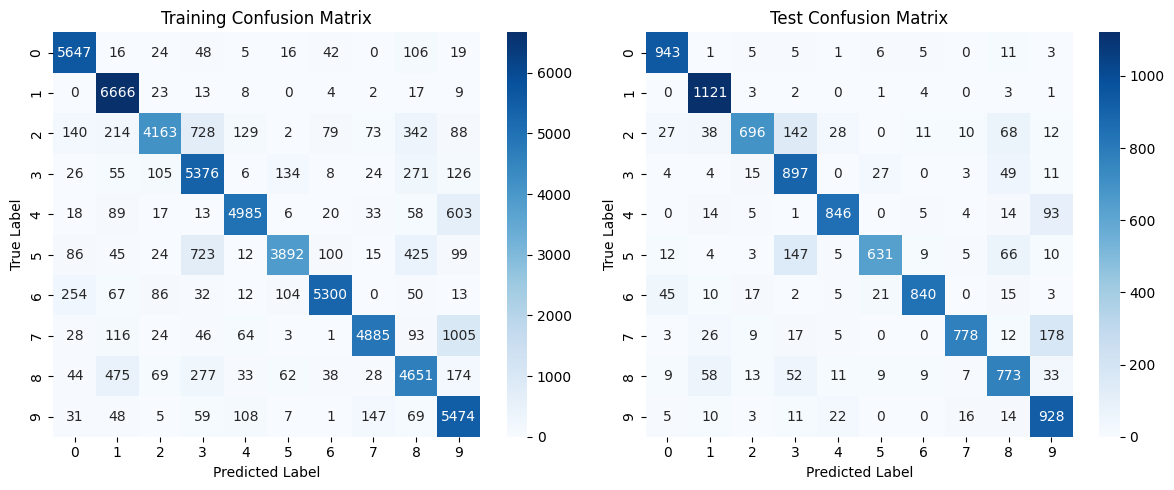

In [26]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrices
train_conf_matrix = confusion_matrix(y_train, y_pred_train)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


# Step 5: Parallel Coordinates Plot and Relative Residuals


<ipython-input-27-2fce9c06cb49>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pd.plotting.parallel_coordinates(df_relative_residuals, 'True Label', colormap=cm.get_cmap('tab10'))


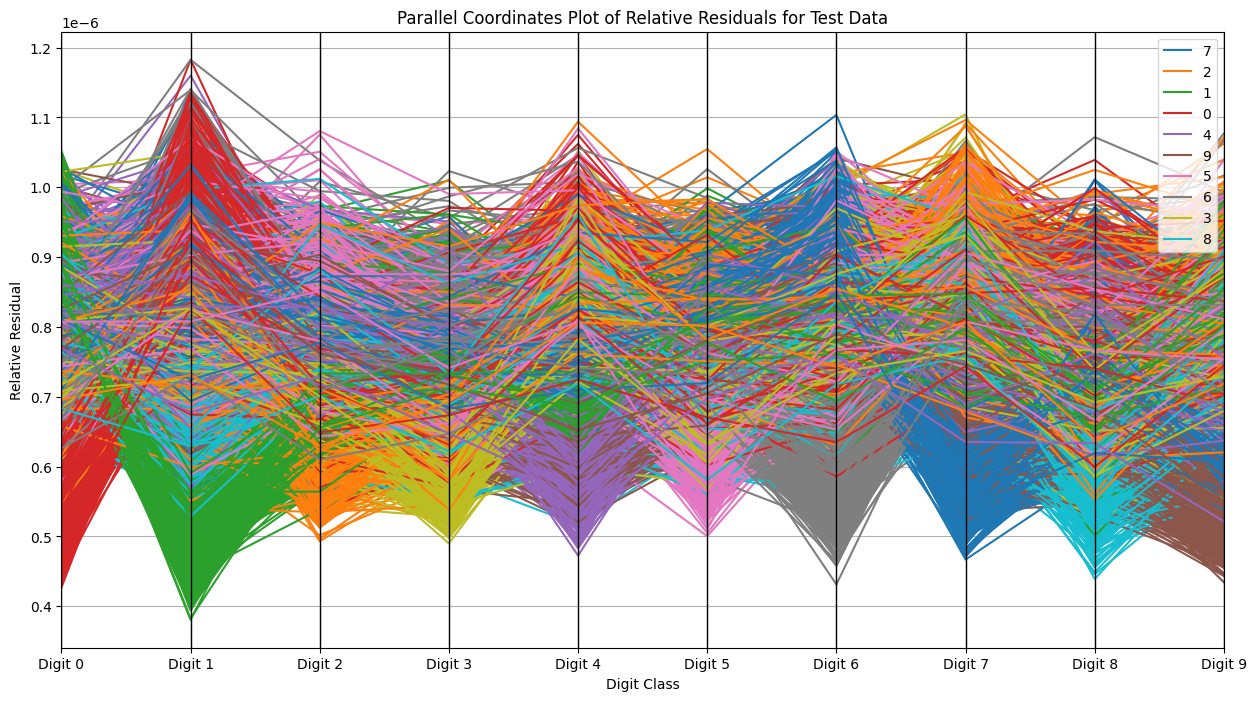

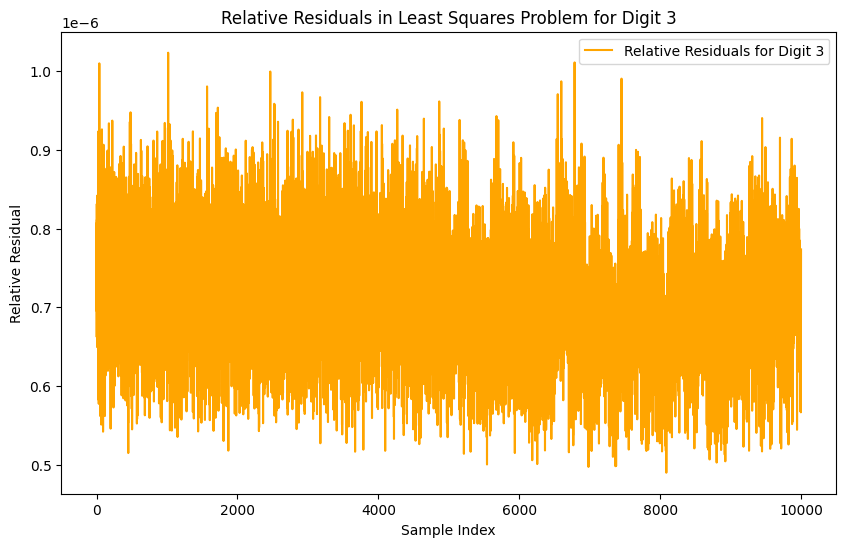

In [27]:
# Parallel Coordinates Plot of Relative Residuals for Unknown Digit Approximations
norms_test = np.linalg.norm(x_test, axis=1, keepdims=True)
relative_residuals_test = residuals_test / norms_test

# Create a DataFrame for plotting
df_relative_residuals = pd.DataFrame(relative_residuals_test, columns=[f'Digit {digit}' for digit in digits])
df_relative_residuals['True Label'] = y_test

# Plot using parallel coordinates
plt.figure(figsize=(15, 8))
pd.plotting.parallel_coordinates(df_relative_residuals, 'True Label', colormap=cm.get_cmap('tab10'))
plt.title('Parallel Coordinates Plot of Relative Residuals for Test Data')
plt.xlabel('Digit Class')
plt.ylabel('Relative Residual')
plt.show()

# Relative Residual in Least Squares Problem for Digit 3
digit = 3
relative_residuals_digit_3 = residuals_test[:, digit] / norms_test[:, 0]

# Plotting the relative residuals
plt.figure(figsize=(10, 6))
plt.plot(relative_residuals_digit_3, label=f'Relative Residuals for Digit {digit}', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Relative Residual')
plt.title(f'Relative Residuals in Least Squares Problem for Digit {digit}')
plt.legend()
plt.show()


# Step 6: Approximations for Digit 3 Using Different Basis Vectors


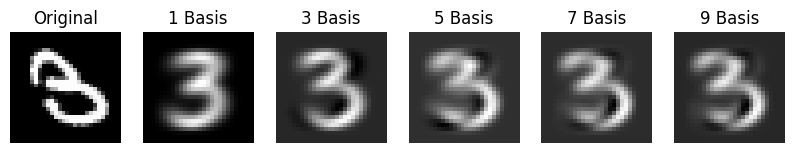

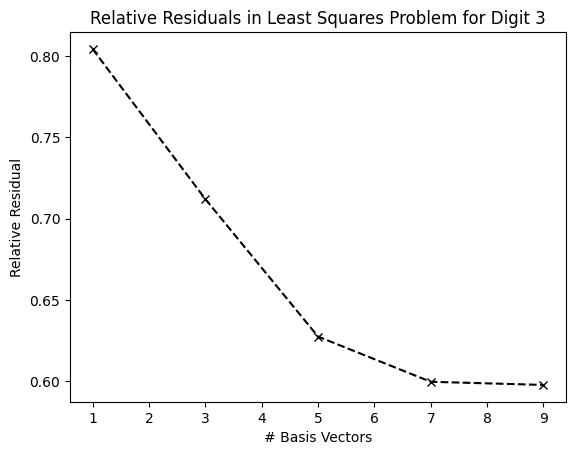

In [33]:
# Select an example digit 3 from the test set
test_idx = np.where(y_test == 3)[0][0]
test_digit = x_test[test_idx]

# List of basis vector counts to use for approximation
basis_counts = [1, 3, 5, 7, 9]

# Store approximations and residuals
approximations = []
residuals = []

for count in basis_counts:
    # Approximate using 'count' basis vectors
    basis_vectors = Vt[3][:count]
    approximation = np.dot(np.dot(test_digit, basis_vectors.T), basis_vectors)
    approximations.append(approximation)

    # Calculate the residual
    residual = np.linalg.norm(test_digit - approximation) / np.linalg.norm(test_digit)
    residuals.append(residual)

# Plot the approximations
plt.figure(figsize=(10, 2))
plt.subplot(1, len(basis_counts) + 1, 1)
plt.imshow(test_digit.reshape(28, 28), cmap='gray')
plt.title('Original')
plt.axis('off')

for i, (approx, count) in enumerate(zip(approximations, basis_counts)):
    plt.subplot(1, len(basis_counts) + 1, i + 2)
    plt.imshow(approx.reshape(28, 28), cmap='gray')
    plt.title(f"{count} Basis")
    plt.axis('off')

plt.show()

# Plot the relative residuals
plt.figure()
plt.plot(basis_counts, residuals, 'kx--')
plt.xlabel('# Basis Vectors')
plt.ylabel('Relative Residual')
plt.title('Relative Residuals in Least Squares Problem for Digit 3')
plt.show()
